# Relax Take Home Challenge

In [15]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [2]:
df1 = pd.read_csv('takehome_user_engagement.csv',encoding = 'utf-8')
df2 = pd.read_csv('takehome_users.csv',encoding = 'latin')

In [4]:
df1.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [5]:
df2.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [6]:
#out of 12000 user ID how many logged in over the period?
len(df1['user_id'].unique())

8823

In [7]:
#set the time_stamp to datetime and the set it as the index
df1.time_stamp = pd.to_datetime(df1.time_stamp)
df1 = df1.set_index('time_stamp', drop= True)

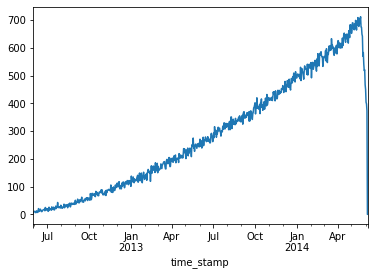

In [8]:

df1['visited'].resample('1D').sum().plot()

In [12]:
engagement=df1.copy()
users=df2.copy()

In [17]:
def label_adopted(x):    
    df_temp = engagement.loc[engagement['user_id'] == x] 
    df_temp = df_temp.resample('D').mean()
    df_temp = df_temp.dropna() 
    adopted = 0
    for i in range(len(df_temp)-2): #loop over active days till the second to last day
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7): # difference between every 1st and 3rd day
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [18]:
#apply to user df to label users as adopted=true 
users['adopted_user'] = users['object_id'].apply(label_adopted)

In [ ]:
users.head()

In [19]:
processed = users.copy()
processed = pd.get_dummies(processed, columns = ['invited_by_user_id'], dummy_na= True) #Just want to know if invited or not
processed = processed[['creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip', 'invited_by_user_id_nan', 'adopted_user']]
processed.rename(columns={'invited_by_user_id_nan': 'Not_invited'}, inplace=True)
processed = pd.get_dummies(processed, columns = ['creation_source']) # convert categorical data
display(processed.head())

,opted_in_to_mailing_list,enabled_for_marketing_drip,Not_invited,adopted_user,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
0,1,0,0,0,1,0,0,0,0
1,0,0,0,1,0,1,0,0,0
2,0,0,0,0,0,1,0,0,0
3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0


# Use Random Forest to test for feature importance


In [23]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import train_test_split


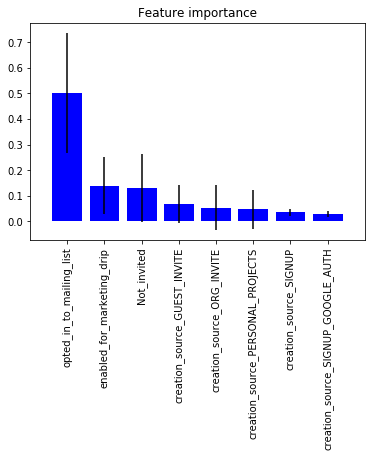

In [30]:
y = processed['adopted_user']
X = processed.drop('adopted_user', axis = 1)

# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=0)

forest.fit(X, y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importance")
plt.bar(range(X.shape[1]), importances[indices],
       color="b", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), feature_names, rotation='vertical')
plt.xlim([-1, X.shape[1]])
plt.show()

## Using the above methond to extract feature importance we understand that opted_in to mailing list and enable for marketing drip were more likely to be adopted users